### Vapor Field in 1 dimension

In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import curve_fit
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
from importlib import reload
from matplotlib import rcParams

# QLC-specific code
import QLCstuff as QLC; reload(QLC)

<module 'QLCstuff' from '/Users/nesh/Documents/Repositories/icecontinuum/nesh/Integrated_QLC_VF/QLCstuff.py'>

In [2]:
%matplotlib notebook
ticklabelsize = 15
linewidth = 1
fontsize = 15
color = 'k'
markersize = 10

### Defining system and run parameters

In [9]:
# Preferred units
distance_unit = 'micrometer'
pressure_unit = 'pascal'
time_unit = 'microsecond'
temperature_unit = 'kelvin'

# Temperature
Temperature = AssignQuantity(250,'kelvin')
print('Temperature =',Temperature)

# Ambient pressure
Pressure = AssignQuantity(100,'pascal')
print('Pressure =', Pressure)

# Diffusion through air
Dvap = QLC.getDofTP(Temperature,Pressure,AssignQuantity)
print('Dvap =',Dvap)

# Size of the box
L = AssignQuantity(150,'micrometer')
print('L =', L)

# The far-field distance
x_f = AssignQuantity(1000,'micrometer')

# The far-field supersaturation
sigmaI_far_field = 0.3
print('sigmaI, far field =',sigmaI_far_field)

# Growth rate of the crystal
g_ice_vapor = AssignQuantity(2,'micrometer/second')
print('g_ice_vapor = ',g_ice_vapor)

# The Neumann parameter "g'"
rho_ice = AssignQuantity(0.9,'g/cm^3')
Mvap = AssignQuantity(18,'g/mol')
R = AssignQuantity(8.314,'J/mol/kelvin')
gprime = rho_ice*g_ice_vapor*R*Temperature/Mvap; #print(gprime)
gprime.ito('pascal * micrometer / second'); #print(gprime)

# Equilibrium vapor stuff
P3 = AssignQuantity(611,'Pa')
T3 = AssignQuantity(273,'kelvin')
Delta_H_sub = AssignQuantity(50,'kJ/mol')
P_vapor_eq = P3*np.exp(-Delta_H_sub/R*(1/Temperature-1/T3))
print('P_vapor_eq =', P_vapor_eq)

# The far-field pressure
P_f = P_vapor_eq * (sigmaI_far_field+1)
print('P_f =', P_f)

# The diffusion coefficient
D = QLC.getDofTP(Temperature,Pressure,AssignQuantity)

Temperature = 250 kelvin
Pressure = 100 pascal
Dvap = 18831.978608777987 micrometer ** 2 / microsecond
L = 150 micrometer
sigmaI, far field = 0.3
g_ice_vapor =  2 micrometer / second
P_vapor_eq = 80.5128693847561 pascal
P_f = 104.66673020018294 pascal


### The 2-D vaporfield simulation code (box inside a far-field box)
Here we've set aspect ratio to be big, to simulate a 1-d run in the x-direction

dx 10.0 micrometer
dy 10.0 micrometer
Using the default dt = 0.001062023296409097 microsecond
Dxeff =  188.31978608777987 / microsecond
Dyeff =  188.31978608777987 / microsecond
uneumannx =  20.784999999999997 pascal / microsecond
uneumanny =  20.784999999999997 pascal / microsecond
Vapor pressure at this temperature =  80.5128693847561 pascal
udirichlet =  104.66673020018294 pascal
Integrating steps =  18831
Integrating out to  19.998960694679706 microsecond
    box Lx =  150.0 micrometer
    box Ly =  750.0 micrometer
    box length (y) =  150
slice(85, 115, None)
slice(25, 175, None)
Shape of u0:
   nx = 201
   ny = 201
Solving using Euler


<IPython.core.display.Javascript object>


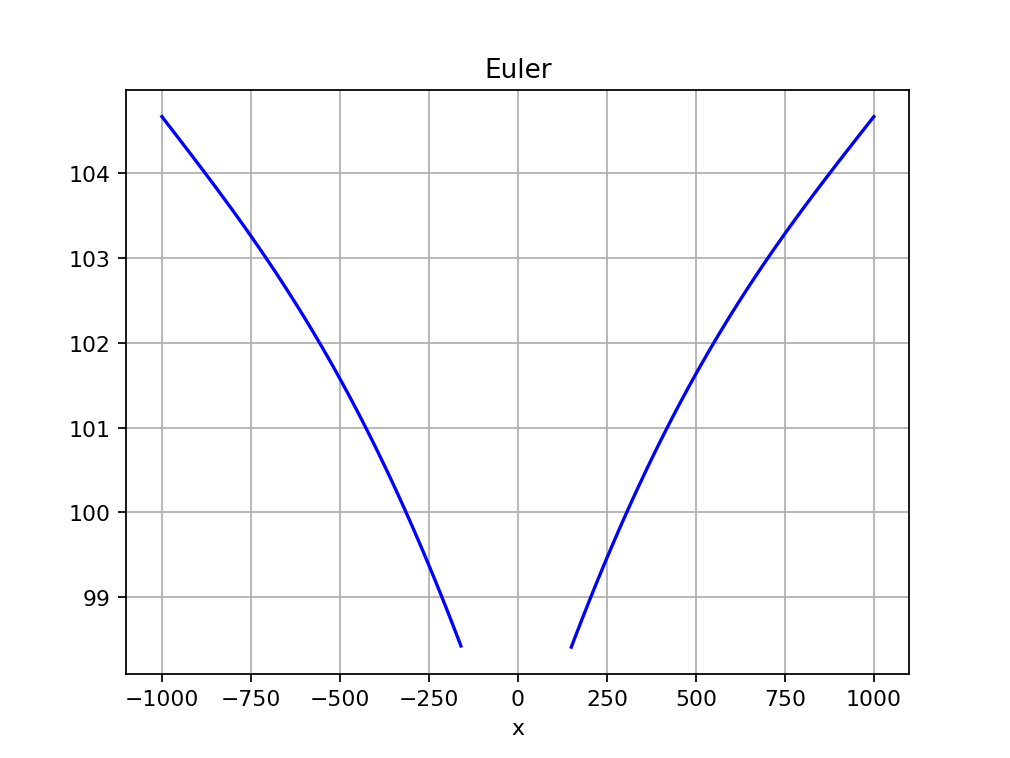

<IPython.core.display.Javascript object>


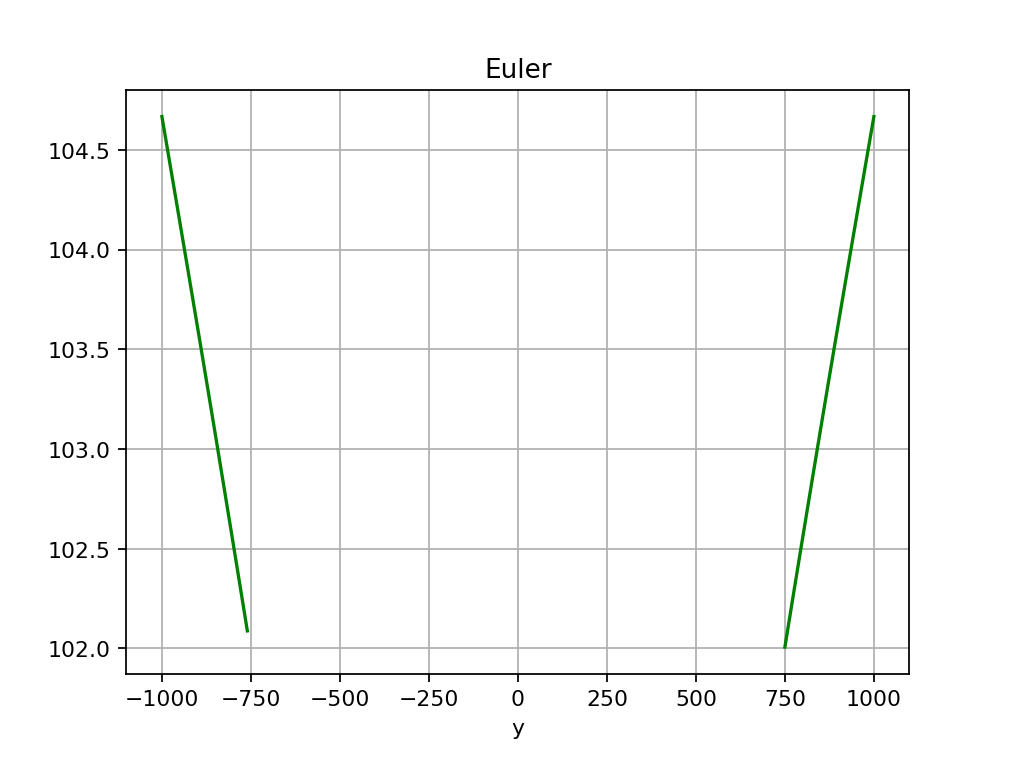

<IPython.core.display.Javascript object>


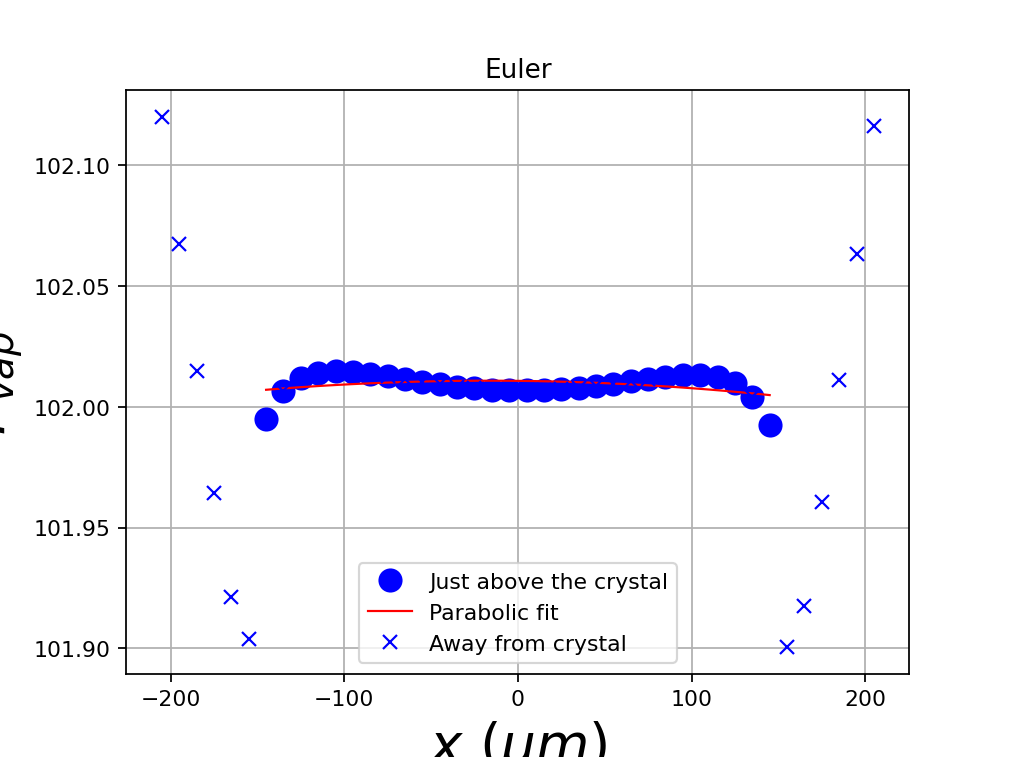

<IPython.core.display.Javascript object>


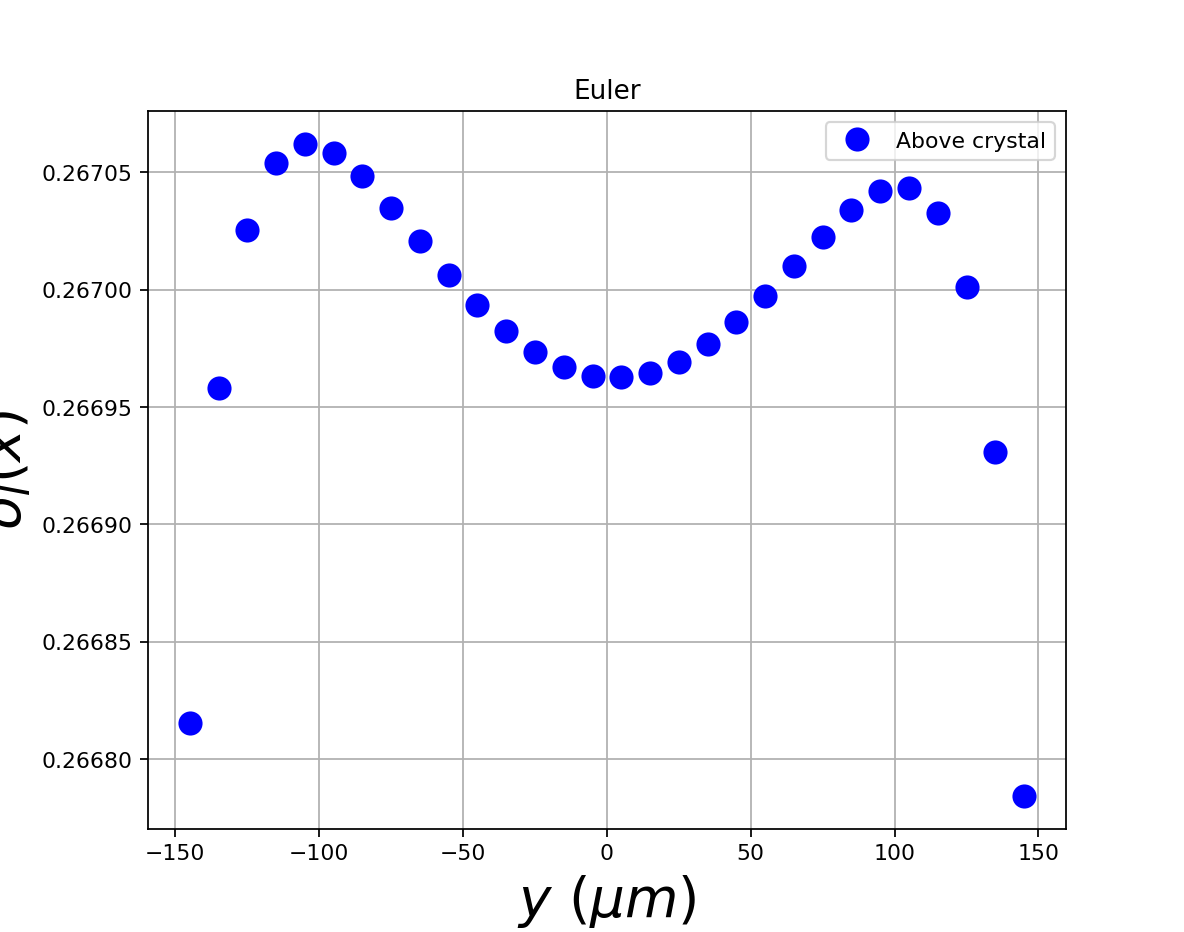

<IPython.core.display.Javascript object>


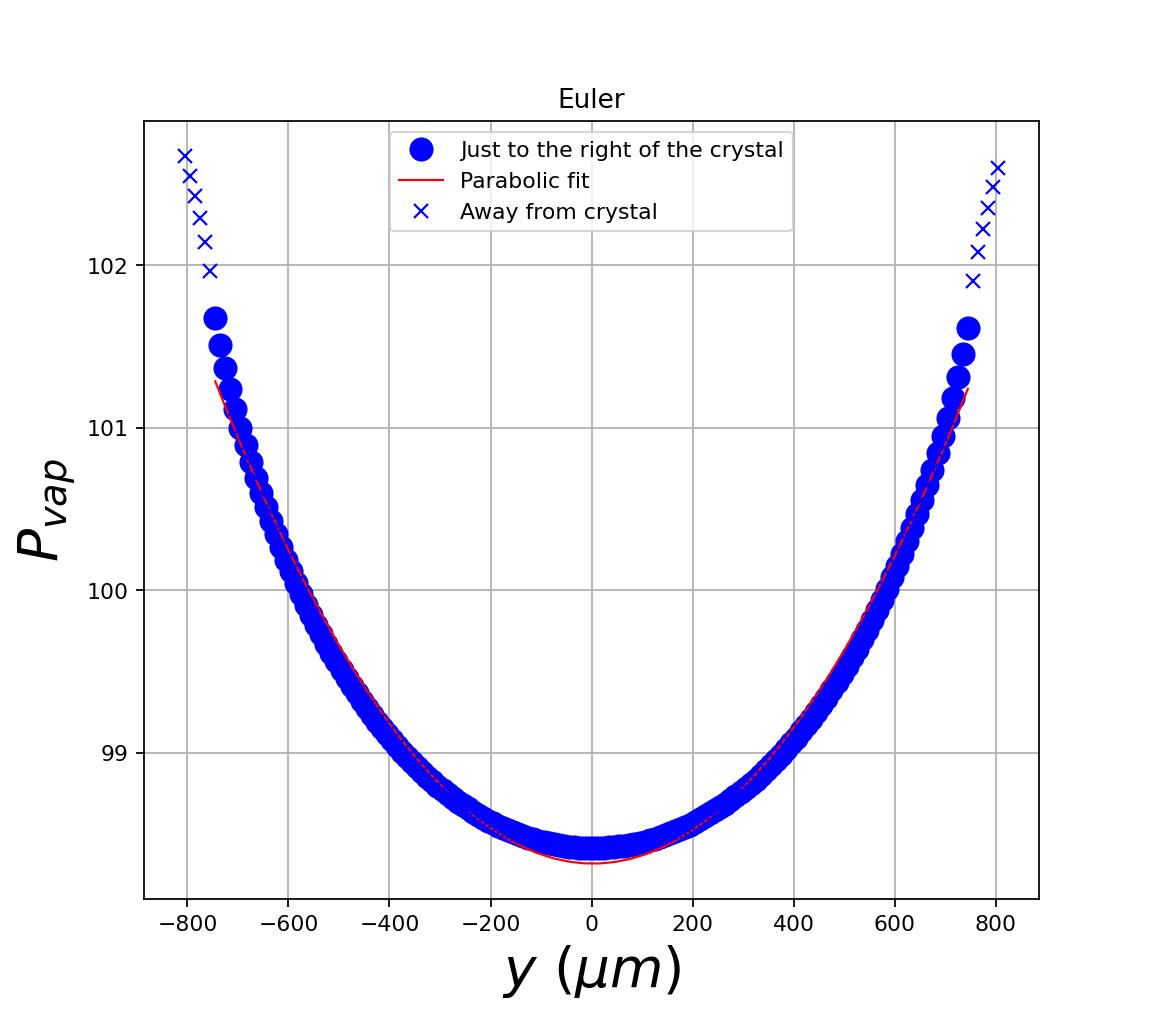

<IPython.core.display.Javascript object>


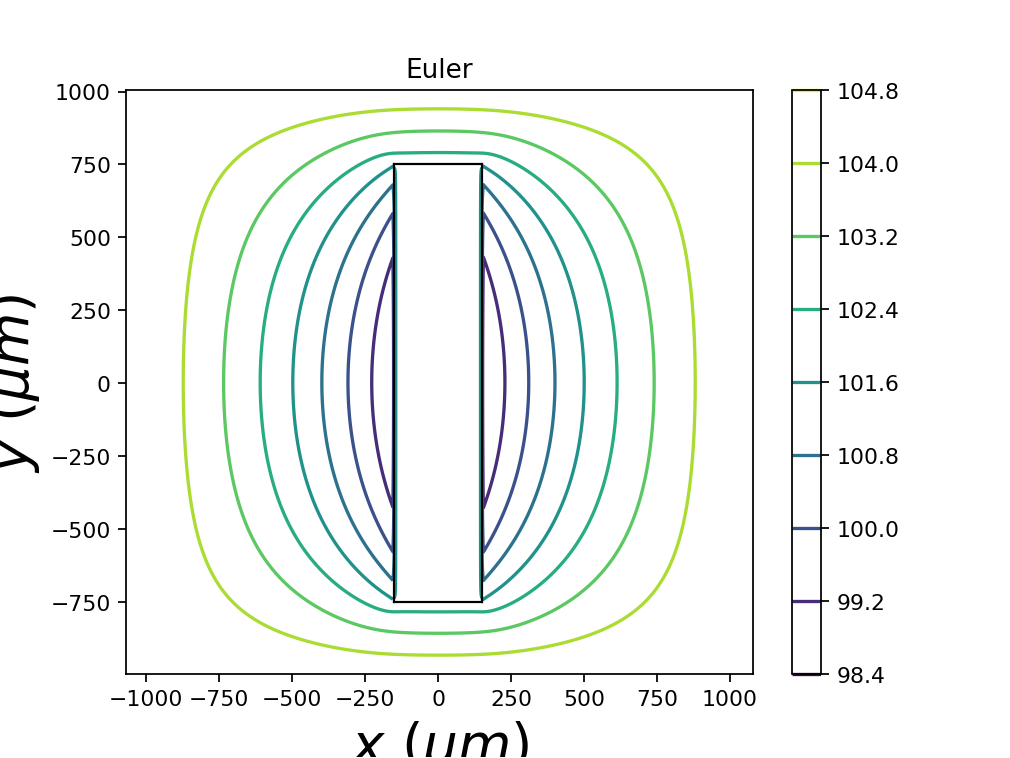

75
At the corner:
   sigmaI = 0.26282839686581827 dimensionless
   Pvap = 101.67393777221857 pascal
At the middle:
   sigmaI at middle =  0.22232902789942188 dimensionless
   Pvap = 98.41321736846206 pascal


In [7]:
# Call the vaporfield code
tmax = AssignQuantity(20,'microsecond')
[x_vapor, sigmaIx_vapor], [y_vapor, sigmaIy_vapor], [x_entire, y_entire, Pvap_entire], [Lx_actual, Ly_actual] = \
    QLC.VF2d(Temperature,Pressure,g_ice_vapor,sigmaI_far_field,L,\
             AssignQuantity, tmax_mag=tmax.magnitude, aspect_ratio=5, verbose=2, xmax_mag=2*x_f.magnitude, \
            nx=201, ny=201)

# Numerical results
ny_crystal = len(sigmaIy_vapor)
imid = int(ny_crystal/2); print(imid)
print('At the corner:')
print('   sigmaI =', sigmaIy_vapor[0])
print('   Pvap =', (sigmaIy_vapor[0]+1)*P_vapor_eq)
print('At the middle:')
print('   sigmaI at middle = ', sigmaIy_vapor[imid])
print('   Pvap =', (sigmaIy_vapor[imid]+1)*P_vapor_eq)

### Analytical solution to the 1-D problem

We're considering the 1-D equation, in which a crystal extending to the right a distance $L$ from the origin, is situated in a box that goes out to $x_f$. We have

$$
{\partial P_{vap} \over \partial t}  = D_{vap} \nabla^2 P_{vap} - g_{ice}' {1 \over \Delta x} \ \ \ \ (1)
$$

where ${1 \over \Delta x}$ simulates a Dirac delta function positioned at $x=L$, and $P_{f}$ is the vapor pressure at the far field ($x_f$), where Dirichlet conditions will be assumed. We presume we can specify $P_{f}$ and $x_f$, because we have data regarding the spacing between ice crystals in cirrus clouds, and the humidity. $g'$ is related to the growth rate of the crystal, $g_{ice}$ (in $\mu m/s$), by

$$
g_{ice}' = g_{ice}  {\rho_{ice} RT \over M_{H_2O}} \ \ \ \ (2)
$$

which we can also specify because we have an idea of how fast ice crystals grow. The steady-state solution to Eq. 1 has the linear form

$$
P_{vap} = m(x-x_f)+P_f  \ \ \ \ (3)
$$

We can find $m$ by saying that, at $L$, the diffusion term becomes

$$
D_{vap} \nabla^2 P_{vap} = D_{vap} \times {dP_{vap} \over dx} \times {1 \over \Delta x} = D_{vap} \times m \times {1 \over \Delta x} \ \ \ \ (4)
$$

so $D m = g_{ice}'$, which means

$$
m = {g_{ice}' \over D} \ \ \ \ (5)
$$

and (using Eq. 3)

$$
P_{vap}(L) = {g_{ice}' \over D}(L-x_f)+P_f  \ \ \ \ (6)
$$

<IPython.core.display.Javascript object>


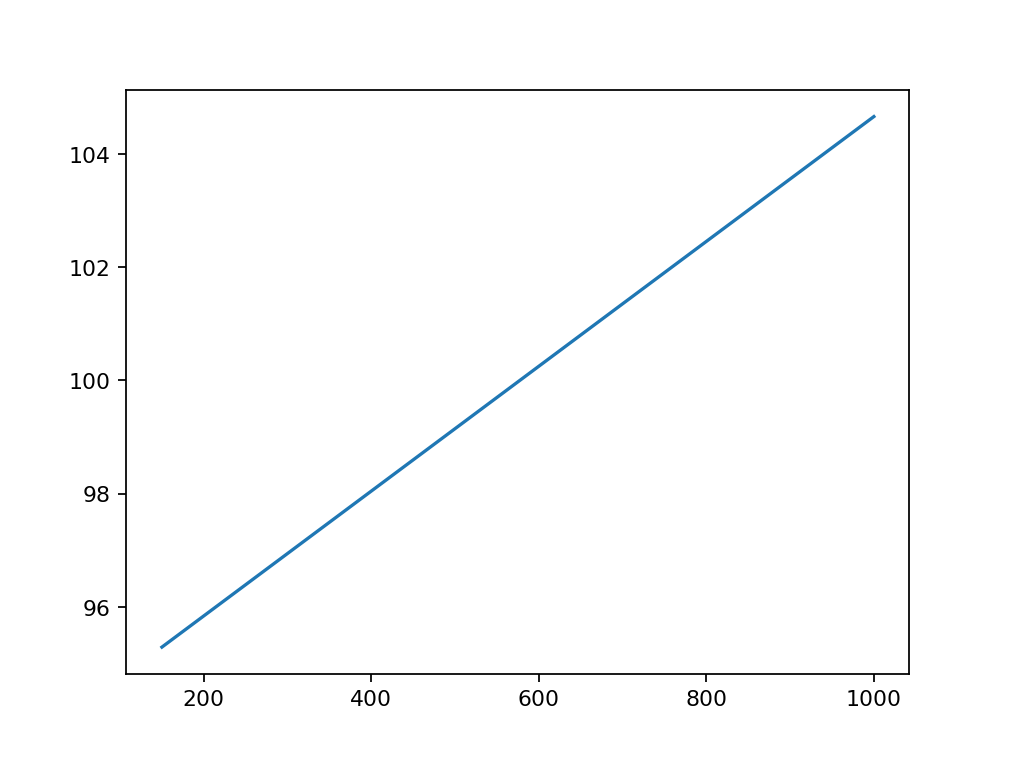

In [23]:
# The analytical solution
x = np.linspace(L,x_f,100)
P_analytical = gprime/D*(x-x_f)+P_f
P_analytical.ito('pascal')
plt.figure()
plt.plot(x,P_analytical)

In [8]:
# The analytical solution
# P_L = gprime/Dvap*(L-x_f)+P_f
# P_L.ito('pascal')
# print('P_L =', P_L)
# sigmaIcorner = (P_L-P_vapor_eq)/P_vapor_eq; print('sigmaI corner =', sigmaIcorner)


[r,un] = VF2d_x1d(Temperature,Pressure,g_ice,sigmaI_far_field,L,\
         AssignQuantity,verbose=2,\
         tmax_mag=, dt=0, nx=151, xmax_mag=1000)

P_L = 95.28521465844112 pascal
sigmaI corner = 0.18347806240876494 dimensionless


<IPython.core.display.Javascript object>


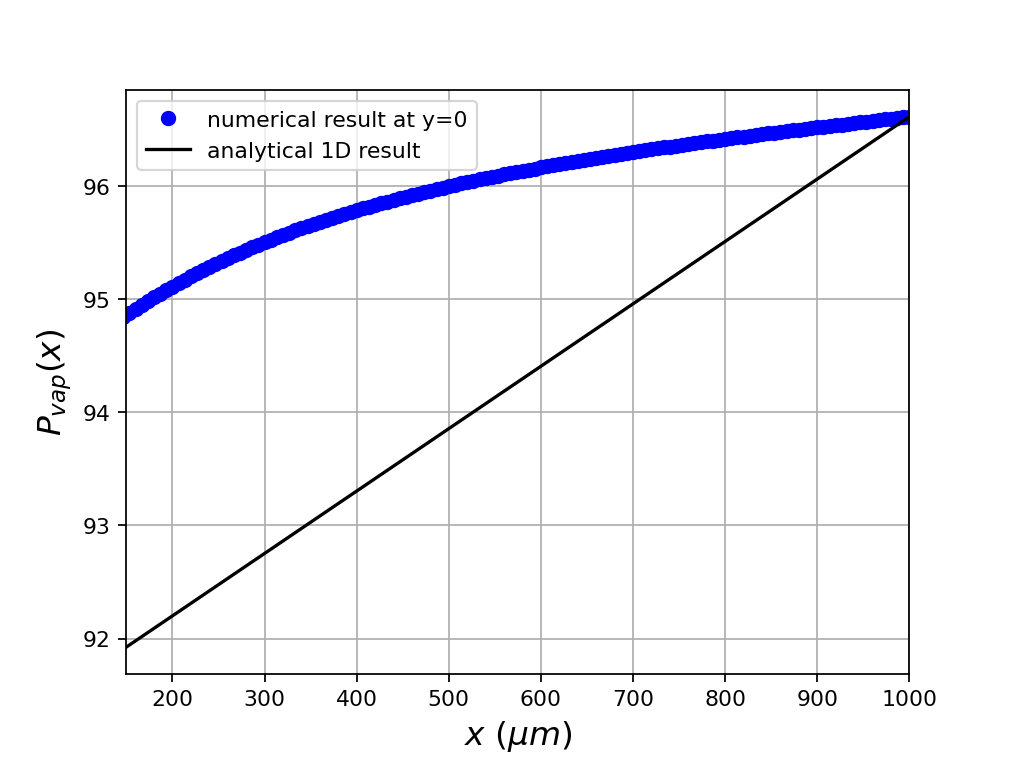

(150.0, 1000.0)

In [25]:
# Plot Pvap(x)
nx, ny = np.shape(Pvap_entire)
ixmid = int(nx/2); iymid=int(ny/2)
Pvap_numerical = Pvap_entire[:,iymid]

# Laying out the 1-D space for the 1-D analytical
x = np.linspace(L,x_f,100)
Pvap_analytical = gprime/Dvap*(x-x_f)+P_f
Pvap_analytical.ito('pascal')

plt.figure()        
plt.plot(x_entire.magnitude,Pvap_numerical,'ob',label='numerical result at y=0')
plt.plot(x.magnitude,Pvap_analytical.magnitude,'-k',label='analytical 1D result')
plt.xlabel(r'$x$ ($\mu m$)', fontsize=fontsize)
plt.ylabel(r'$P_{vap}(x)$',fontsize=fontsize)
plt.grid(True)
plt.legend()
plt.xlim(L.magnitude,x_entire[-1].magnitude)

### Analytical solution in polar coordinates 
The trial function is

$$
P = P_1 \times (1-{r_0 \over r})
$$

$$
{\partial P_{vap} \over \partial t}  = D_{vap} \nabla^2 P_{vap} - g_{ice}' {1 \over \Delta x} \ \ \ \ (1)
$$


Lx_actual = 146.66666666666669 micrometer
r_eff = 186.74179989449055 micrometer
fudge factor for r = 1
r_eff = 186.74179989449055 micrometer
gprimeprime = 1.9918682591123646 micrometer
r_0 = 1.9879086070559535 micrometer
P1 = 96.80788849648039 pascal
P_f = 96.61544326170731 pascal
P_f_test = 96.61544326170731 pascal
95.77734667412568 pascal
r_0_test = 1.9879086070559535 micrometer


<IPython.core.display.Javascript object>


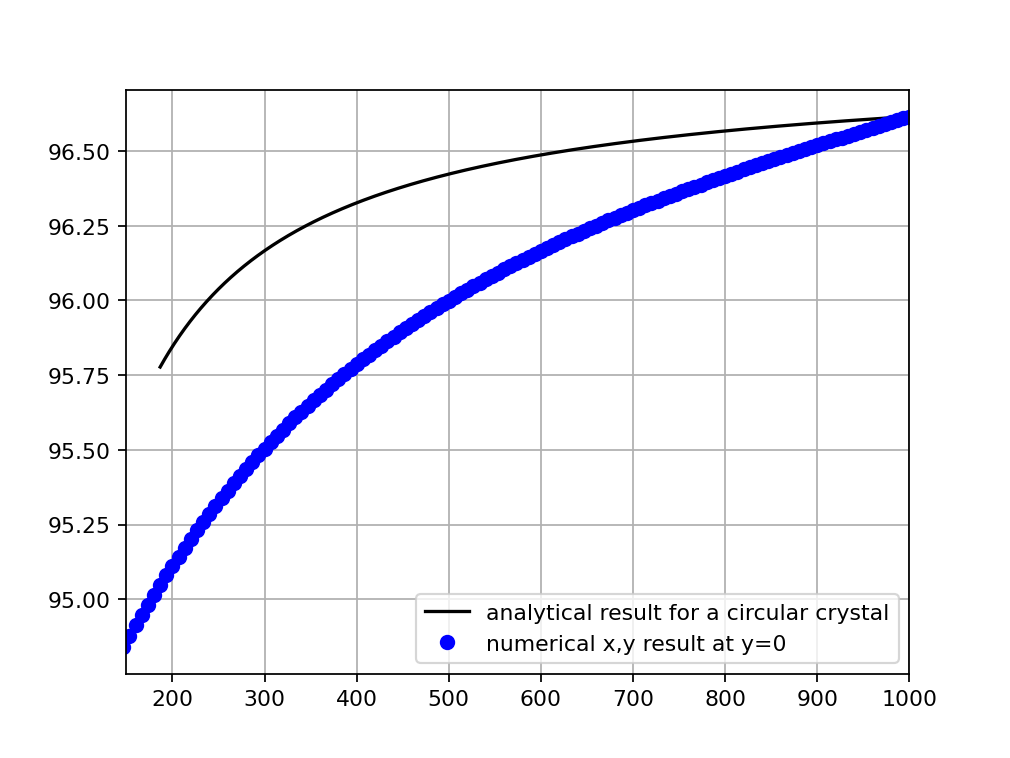

<IPython.core.display.Javascript object>


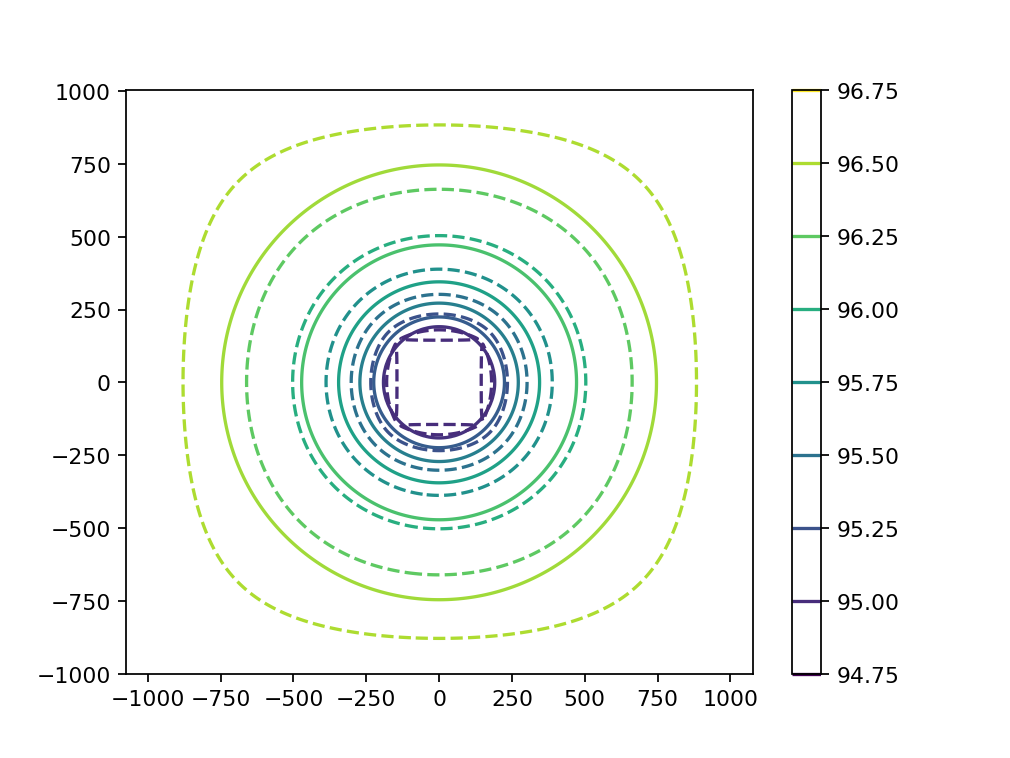

/Users/nesh/anaconda3/lib/python3.10/site-packages/pint/facets/plain/quantity.py:998: RuntimeWarning: divide by zero encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


In [26]:
r_f = x_f # far field distance

circumference_of_crystal = 8*Lx_actual
r_eff = circumference_of_crystal/(2*np.pi)
print('Lx_actual =', Lx_actual)
print('r_eff =',r_eff)



rfactor = 1
print('fudge factor for r =',rfactor)
r_eff *= rfactor
print('r_eff =',r_eff)

gprimeprime = gprime*r_eff**2/Dvap/P_f
gprimeprime.ito('micrometer')
print('gprimeprime =',gprimeprime)
r_0 = gprimeprime/(1+gprimeprime/r_f)
print('r_0 =',r_0)
P1 = P_f/(1-r_0/r_f)
print('P1 =',P1)
P_f_test = P1*(1-r_0/r_f)
print('P_f =',P_f)
print('P_f_test =',P_f_test)
P_L = P1*(1-r_0/r_eff)
print(P_L)
r_0_test = gprime*r_eff**2/P1/Dvap
r_0_test.ito('micrometer')
print('r_0_test =',r_0_test)

r = np.linspace(r_eff,r_f,1000)
P = P1*(1-r_0/r)
plt.figure()
plt.plot(r,P,'k-',label='analytical result for a circular crystal')
plt.plot(x_entire.magnitude,Pvap_numerical,'ob',label='numerical x,y result at y=0')
plt.xlim(L.magnitude,x_entire[-1].magnitude)
plt.legend()
plt.grid(True)

fig,ax = plt.subplots()
ax.axis('equal')
x_grid,y_grid = np.meshgrid(x_entire,y_entire)
rgrid = np.sqrt(x_grid**2+y_grid**2)
Pgrid = P1*(1-r_0/rgrid)
for i in range(len(x_entire.magnitude)):
    for j in range(len(y_entire.magnitude)):
        if Pgrid[i,j]<P_L:
            Pgrid[i,j]=P_L
dx = x_entire.magnitude[1]-x_entire.magnitude[0]; xshift = dx/2
dy = y_entire.magnitude[1]-y_entire.magnitude[0]; yshift = dy/2

CS = ax.contour(x_entire.magnitude, y_entire.magnitude, Pgrid.magnitude)
CS = ax.contour(x_entire.magnitude+xshift, y_entire.magnitude+yshift, Pvap_entire.magnitude,linestyles='dashed')

fig.colorbar(CS)

### Numerical solution in polar coordinates

In [27]:
r_1d,un_1d = QLC.VF2d_r1d(Temperature,Pressure,g_ice_vapor,sigmaI_far_field,r_eff,\
         AssignQuantity,verbose=1,\
         tmax_mag=tmax.magnitude, dt=0, nr=nx, rmax_mag=1000)

uneumann =  38.33653321411979 pascal / microsecond
Vapor pressure at this temperature =  80.5128693847561 pascal
udirichlet =  96.61544326170731 pascal
Integrating steps =  1153171
Integrating out to  14.999987523019675 microsecond


<IPython.core.display.Javascript object>


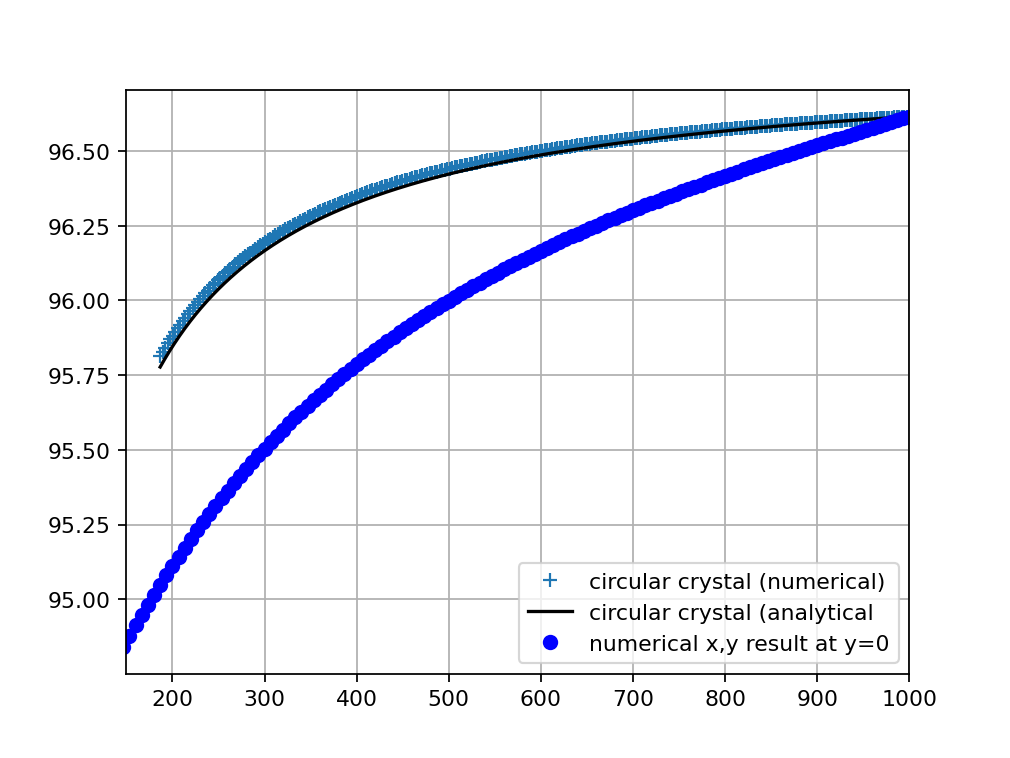

In [39]:
plt.figure()
plt.plot(r_1d,un_1d,'+',label='circular crystal (numerical)')
plt.plot(r,P,'k-',label='circular crystal (analytical')
plt.plot(x_entire.magnitude,Pvap_numerical,'ob',label='numerical x,y result at y=0')
plt.legend()
plt.xlim(L.magnitude,x_entire[-1].magnitude)
plt.grid(True)

### Exploring the 1-D situation

### Fitting solutions to the numerical 2-D box problem
Here we're trying to see if we can fit Pvap away from the surface.

In [30]:
# # Extract the numerical part in that range
# iL = int(L/x_f*nx/2)+ixmid
# x_fit = x_entire[iL:]
# # Pvap_numerical = Pvap_numerical[iL:]

# def expfun(x,a,b,c):
#     P = a + b*(1 - np.exp(-x/c))
#     return P
# from scipy import optimize

# # A fit
# P_L_start = Pvap_numerical[iL:][0]
# P_L_stop = Pvap_numerical[iL:][-1]
# Delta_P_L = P_L_stop-P_L_start
# x_constant = AssignQuantity(250,'micrometer')
# p0 = [P_L_start.magnitude, Delta_P_L.magnitude, x_constant.magnitude]
# print(p0)
# P_L, Delta_P_L, x_constant = optimize.curve_fit(\
#             expfun, xdata = x_fit.magnitude, ydata = Pvap_numerical[iL:], p0=p0)[0]

# print(P_L, Delta_P_L, x_constant)
# P_bestfit = expfun(x_fit.magnitude,P_L,Delta_P_L,x_constant)
# P_bestfit = AssignQuantity(P_bestfit,'pascal')
# plt.figure()        
# plt.plot(x_entire.magnitude,Pvap_numerical.magnitude,'o',label='numerical result at y=0')
# plt.plot(x_fit.magnitude,P_bestfit.magnitude,'-k',label='best-fit')
# plt.xlabel(r'$x$ ($\mu m$)', fontsize=fontsize)
# plt.ylabel(r'$P_{vap}(x)$',fontsize=fontsize)
# plt.grid(True)
# plt.legend()
# plt.xlim(L.magnitude,x_entire[-1].magnitude)

# print('Best-fit value of P_f =', P_L+Delta_P_L)
# print('Actual value of P_f =',P_f)

# print('r_0 =',x_constant)
# print('P_L =', P_L)

### Testing the 0d QLC code

In [35]:
# # Time steps
# ntimes = 200
# tlast = AssignQuantity(1000,'microsecond')
# tkeep_0Darr = np.linspace(0,tlast.magnitude,ntimes)
# tkeep_0Darr = AssignQuantity(tkeep_0Darr,'microsecond')
# sigmaI_corner = sigmaIx_vapor[0]; print(sigmaI_corner)

# # Initialize as a pre-equilibrated layer of liquid over ice
# Ntot_init_0D = 0
# NQLL_init_0D = QLC.getNQLL(Ntot_init_0D,Nstar,Nbar)

# # Solve
# Ntotkeep_0D, NQLLkeep_0D = QLC.run_f0d(\
#             NQLL_init_0D, Ntot_init_0D, tkeep_0Darr,\
#             Nbar, Nstar, sigma0, nu_kin_mlyperus, tau_eq, sigmaI_corner)
# Nicekeep_0D = Ntotkeep_0D - NQLLkeep_0D

# # Report
# g_ice_QLC = QLC.report_0d_growth_results(\
#             tkeep_0Darr,NQLLkeep_0D,Ntotkeep_0D,Nicekeep_0D,Nbar,Nstar,nmpermonolayer)
# print('growth rates ... ')
# print('   from previous vaporfield = ',g_ice_vapor)
# print('   from QLC = ',g_ice_QLC)

### Now the 0d self-consistency loop

In [36]:
# print('g_ice should be smaller than ', sigmaI_far_field*nu_kin)

# for i in range(5):
    
#     # Update the growth rate from the last QLC run
#     g_ice_vapor = (g_ice_vapor+g_ice_QLC)/2

#     # Call the vaporfield code
#     [x_vapor, sigmaIx_vapor], [y_vapor, sigmaIy_vapor] = \
#         QLC.VF2d(Temperature,Pressure,g_ice_vapor,sigmaI_far_field,L,\
#                  AssignQuantity,tmax=tmax)
    
#     # Use sigmaIx for sigmaI
#     sigmaI_QLC = np.interp(x_QLC,x_vapor,sigmaIx_vapor)
#     c_r = (np.max(sigmaI_QLC)-np.min(sigmaI_QLC))/np.max(sigmaI_QLC)
#     c_r_percent = c_r*100
    
#     # But adjusting it because the vaporfield code isn't symmetrical
#     alpha = c_r*np.max(sigmaIx_vapor)/x_vapor[-1]**2
#     sigmaI_QLC = alpha*x_QLC**2+np.min(sigmaIx_vapor)
#     ix_QLC_mid = int(len(x_QLC)/2)
#     for i in range(0,ix_QLC_mid):
#         sigmaI_QLC[-i-1] = sigmaI_QLC[i]
        
#     # Don't forget to assign the corner supersaturation
#     sigmaI_corner = sigmaIx_vapor[0]

#     # Solve the 0d QLC trajectory with the revised sigmaI
#     Ntotkeep_0D, NQLLkeep_0D = QLC.run_f0d(\
#             NQLL_init_0D, Ntot_init_0D, tkeep_0Darr,\
#             Nbar, Nstar, sigma0, nu_kin_mlyperus, tau_eq, sigmaI_corner)
#     Nicekeep_0D = Ntotkeep_0D - NQLLkeep_0D

#     # Report
#     g_ice_QLC = QLC.report_0d_growth_results(\
#                 tkeep_0Darr,NQLLkeep_0D,Ntotkeep_0D,Nicekeep_0D,Nbar,Nstar,nmpermonolayer,graphics=False)
#     print('growth rates ... ')
#     print('   from previous vaporfield = ',g_ice_vapor)
#     print('   from QLC = ',g_ice_QLC)
#     print('   difference = ',g_ice_vapor-g_ice_QLC)

# print('Done with the 0d self-consistency loop')
# print('c_r = ', c_r_percent, '%')

### Testing the 1d QLC code

In [37]:
# # Estimating/deciding on how long to make the integration
# print('Estimating times for the trajectory run')
# L_reference = AssignQuantity(1,'millimeter')
# time_reference = AssignQuantity(1,'millisecond')
# tlast_estimated = (L*L_reference/D*time_reference)**.5*1.1
# tlast_estimated.ito('millisecond'); print('   time (est) = ', tlast_estimated)
# tlast_msec = tlast_estimated; print('   time (used) = ',tlast_msec)
# tlast = tlast_msec.to('microsecond')

# # Number of time steps to report back
# ntimes = 100
# tkeep_1Darr = np.linspace(0,tlast,ntimes)
# print('   dt =', tkeep_1Darr[1]-tkeep_1Darr[0])

# # Initialize as a pre-equilibrated layer of liquid over ice
# Ntot_init_1D = np.ones(nx)
# NQLL_init_1D = QLC.getNQLL(Ntot_init_1D,Nstar,Nbar)

# # Solve
# Ntotkeep_1D, NQLLkeep_1D = QLC.run_f1d(\
#                 NQLL_init_1D, Ntot_init_1D, tkeep_1Darr,\
#                 Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq, sigmaI_QLC,
#                 AssignQuantity,\
#                 verbose=0, odemethod='LSODA')
# Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D

# # Report
# g_ice_QLC = QLC.report_1d_growth_results(x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,nmpermonolayer)
# print('growth rates ... ')
# print('   from previous vaporfield = ',g_ice_vapor)
# print('   from QLC = ',g_ice_QLC)

### Now the 1d self-consistency loop

In [38]:
# for i in range(2):
    
#     # Update the growth rate from the last QLC run
#     g_ice_vapor = (g_ice_vapor+g_ice_QLC)/2
#     print('g_ice should be smaller than ...')
#     print('   sigmaI_far_field x nu_kin = ', sigmaI_far_field*nu_kin)

#     # Call the vaporfield code
#     [x_vapor, sigmaIx_vapor], [y_vapor, sigmaIy_vapor] = \
#         QLC.VF2d(Temperature,Pressure,g_ice_vapor,sigmaI_far_field,L,\
#                  AssignQuantity,verbose=0,tmax=tmax)
    
#     # Use sigmaIx for sigmaI
#     sigmaI_QLC = np.interp(x_QLC,x_vapor,sigmaIx_vapor)
#     c_r = (np.max(sigmaI_QLC)-np.min(sigmaI_QLC))/np.max(sigmaI_QLC)
#     c_r_percent = c_r*100
    
#     # But adjusting it because the vaporfield code isn't symmetrical
#     beta = c_r*np.max(sigmaIx_vapor)/x_vapor[-1]**2
#     sigmaI_QLC = beta*x_QLC**2+np.min(sigmaIx_vapor)
#     ix_QLC_mid = int(len(x_QLC)/2)
#     for i in range(0,ix_QLC_mid):
#         sigmaI_QLC[-i-1] = sigmaI_QLC[i]

#     # Solve the QLC trajectory with the revised sigmaI
#     Ntotkeep_1D, NQLLkeep_1D = QLC.run_f1d(\
#                     NQLL_init_1D, Ntot_init_1D, tkeep_1Darr,\
#                     Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq, sigmaI_QLC,
#                     AssignQuantity,\
#                     verbose=0, odemethod='LSODA')
#     Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D

#     # Report
#     g_ice_QLC = QLC.report_1d_growth_results(x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,nmpermonolayer)
#     print('From vapor simulation ... ')
#     print("c_r = " + "{:.3f}".format(c_r_percent.magnitude)+'%')
#     print('growth rates ... ')
#     print('   from previous vaporfield = ',g_ice_vapor)
#     print('   from QLC = ',g_ice_QLC)
#     print('   difference = ',g_ice_vapor-g_ice_QLC)

# alpha = g_ice_QLC/(sigmaI_far_field*nu_kin)
# print('alpha =',alpha)

# lastfraction = 0.3
# itimes_almost_end = int(ntimes*(1-lastfraction))
# f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
# nsteps_ss = np.mean(f[itimes_almost_end:-1])
# print('nsteps average of last', lastfraction*100, '% (', ntimes-itimes_almost_end, 'points) =', nsteps_ss)
# lambda_average = L/nsteps_ss
# print('estimated lambda =', lambda_average)